In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.integrate import simps
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

from mne import Epochs, pick_types, events_from_annotations, EpochsArray, create_info
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import psd_array_welch, psd_array_multitaper, stft
import seaborn as sns
from tqdm import tqdm

In [ ]:
# torch/fastai

import snntorch as snn
import sys
import sklearn as sk
import platform
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from fastai.tabular.all import *

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"
default_device(torch.device(device))

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

In [2]:
# keras/tensorflow

import sys
import tensorflow.keras as keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.3.1-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas 1.5.2
Scikit-Learn 1.2.0
GPU is available


In [3]:
# load batch_stft.npy and train_idx.npy
# reconstructed_stft = np.load('preprocessed_data/reconstructed_stft.npy')
source_stft = np.load('preprocessed_data/source_stft.npy')
train_idx = np.load('preprocessed_data/train_idx.npy')
val_idx = np.load('preprocessed_data/val_idx.npy')
test_idx = np.load('preprocessed_data/test_idx.npy')
labels = np.load('preprocessed_data/labels.npy')
freqs = np.load('preprocessed_data/freq.npy')
times = np.load('preprocessed_data/time.npy')



In [4]:
train_stft = source_stft[train_idx]
val_stft = source_stft[val_idx]
test_stft = source_stft[test_idx]
# train_stft = reconstructed_stft[train_idx]
# val_stft = reconstructed_stft[val_idx]

y_train = labels[train_idx]
y_val = labels[val_idx]
y_test = labels[test_idx]

welch_train = np.mean(train_stft, axis=3)
welch_val = np.mean(val_stft, axis=3)
welch_test = np.mean(test_stft, axis=3)

print(welch_train.shape)
print(y_train.shape)

(3725, 4, 81)
(3725,)


In [ ]:
scaling_factor = 1e6
f = 10
train_flat = np.moveaxis(welch_train[:, :, :f], 1, 0).reshape(4, -1)
labels_flat = (y_train.reshape(-1, 1) * np.ones((1, f))).flatten() 

i = 0
j = 3
plt.figure(figsize=(8, 8))
plt.scatter(train_flat[i, :]*scaling_factor, train_flat[j, :]*scaling_factor, c=labels_flat[:], cmap='bwr')

# Add labels and a title
plt.xlabel('Component {}, {} hz power'.format(i, freqs[f]))
plt.ylabel('Component {}, {} hz power'.format(j, freqs[f]))
plt.title('Scatter plot of Component-wise power')

plt.show();

In [6]:
# numerical integration over PSD as a means of dim reduction and calculating band powers
# bandpower is calculated using the non-log-transformed PSD

def abs_band_power(low, high, freqs, psd):
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return simps(psd[:, :, idx_band], dx=freq_res)

def rel_band_power(low, high, freqs, psd):
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return simps(psd[:, :, idx_band], dx=freq_res) / simps(psd, dx=freq_res)

def featurize(welch, freqs, times, log=True):
    welch = 10**(welch/10) if log else welch
    mu = abs_band_power(7, 12, freqs, welch)
    beta = abs_band_power(13, 30, freqs, welch)
    mu_beta_ratio = mu / beta
    rel_mu = rel_band_power(7, 12, freqs, welch)
    rel_beta = rel_band_power(13, 30, freqs, welch)
    return np.concatenate([mu, beta, mu_beta_ratio, rel_mu, rel_beta], axis=1)

def featurize_log(welch, freqs, times): # no need for rel band power, powers are already relative to total in log space
    mu = abs_band_power(7, 12, freqs, welch)
    beta = abs_band_power(13, 30, freqs, welch)
    mu_beta_ratio = mu / beta
    return np.concatenate([mu, beta, mu_beta_ratio], axis=1)
    


In [7]:
# fit mean and std for normalization on all data
# welch_all = np.mean(source_stft, axis=3)[:, :, np.logical_and(freqs >= 8, freqs <= 30)]
# welch_all = welch_all.reshape(welch_all.shape[0], -1)
# print(welch_all.shape)
scaler = StandardScaler() # only fit on training data to avoid data leakage
# scaler.fit(welch_all)

# log psd features in sensorimotor range
X_train = welch_train[:, :, np.logical_and(freqs >= 8, freqs <= 30)]
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
print(X_train.shape)

X_val = welch_val[:, :, np.logical_and(freqs >= 8, freqs <= 30)]
X_val = scaler.transform(X_val.reshape(X_val.shape[0], -1))
print(X_val.shape)

X_test = welch_test[:, :, np.logical_and(freqs >= 8, freqs <= 30)]
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1))
print(X_test.shape)

# band power features
# features_train = featurize(welch_train, freqs, times)
# X_train = scaler.fit_transform(features_train)

# features_val = featurize(welch_val, freqs, times)
# X_val = scaler.fit_transform(features_val)

# print(X_train.shape)
# print(X_val.shape)

# # shuffle split the remaining data between test and validation
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
# test_idx, val_idx = next(sss.split(source_stft[~train_idx], labels[~train_idx]))



(3725, 92)
(466, 92)
(466, 92)


In [96]:
# export test idx
np.save('preprocessed_data/test_idx.npy', test_idx)

# Logistic Regression Prelim Tests

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       237
           1       0.63      0.65      0.64       229

    accuracy                           0.64       466
   macro avg       0.64      0.64      0.64       466
weighted avg       0.64      0.64      0.64       466

ROC AUC: 0.6417095056473753


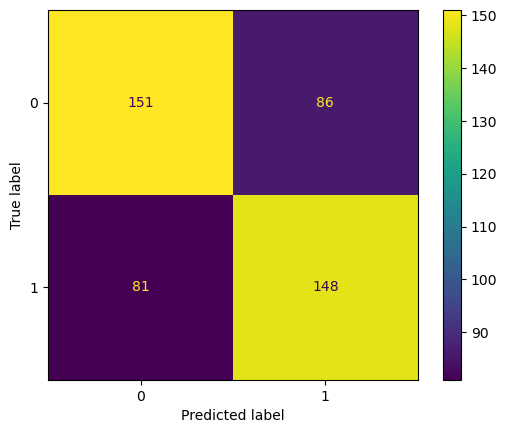

In [11]:
# train logistic regression model

# Fit a logistic regression model
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_val)

# Compute accuracy score
# accuracy = accuracy_score(y_val, y_pred)
confusion = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
roc = roc_auc_score(y_val, y_pred)

# print('Accuracy:', accuracy)
print(class_report)
print('ROC AUC:', roc)
ConfusionMatrixDisplay(confusion).plot();




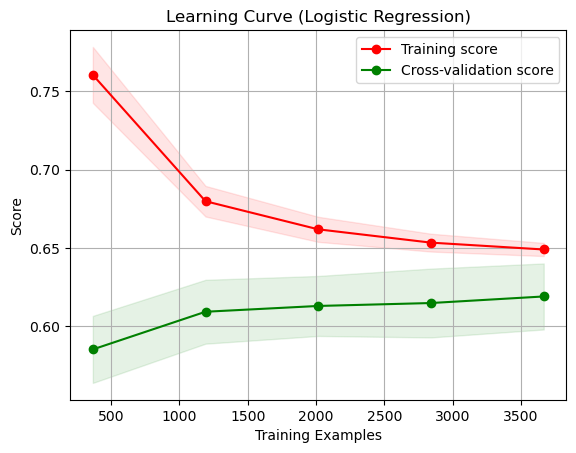

In [127]:
# create a logistic regression classifier
# clf = LogisticRegression(solver='lbfgs', max_iter=1000)

# merge train and val 
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

# set the common parameters for learning curve
common_params = {
    "estimator": clf,
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.125, random_state=0), # 10% of overall data used for validation
    "n_jobs": -1,
    "shuffle": True,
}

# calculate the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(**common_params)

# plot the learning curve
plt.figure()
plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training Examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


In [128]:
print(np.mean(test_scores[-1]))

0.6188931297709924


(6724, 92)
(82, 82)


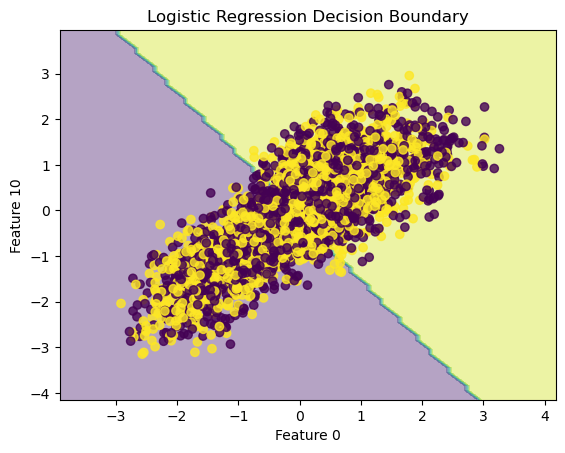

In [129]:
# Extract the coefficients and intercept of the logistic regression model
coef = clf.coef_.ravel()
intercept = clf.intercept_ 

# Select two features to plot the decision boundary
i = 0
j = 10

# Create a grid of points to evaluate the decision boundary
xmin, xmax = X[:, i].min() - 1, X[:, i].max() + 1
ymin, ymax = X[:, j].min() - 1, X[:, j].max() + 1
xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.1), np.arange(ymin, ymax, 0.1))

# Create input vector for model
# Fill with zeros for features that are not i or j
X_pred = np.zeros((len(xx.ravel()), X_train.shape[1]))
X_pred[:, i] = xx.ravel()
X_pred[:, j] = yy.ravel()
print(X_pred.shape)

Z = clf.predict(X_pred)
# Reshape the predictions to match the shape of the meshgrid
Z = Z.reshape(xx.shape)
print(Z.shape)

# Plot the decision boundary and the training data
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, i], X[:, j], c=y, alpha=0.8)
plt.xlabel('Feature {}'.format(i))
plt.ylabel('Feature {}'.format(j))
plt.title('Logistic Regression Decision Boundary')
plt.show()



(4191, 2)


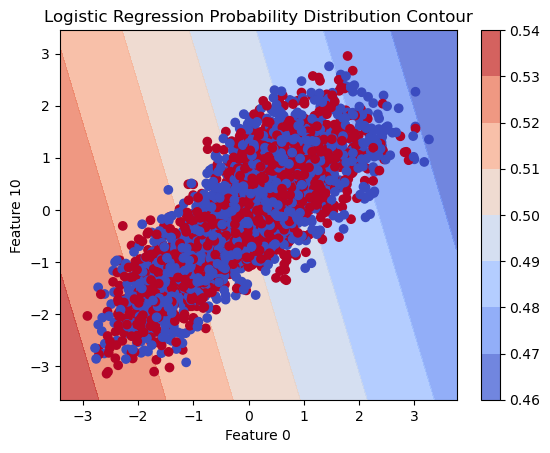

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# build data from 2 features
i = 0
j = 10
X_ij = X[:, [i, j]]
print(X_ij.shape)

# Fit the logistic regression model to the training set
clf = LogisticRegression().fit(X_ij, y)

# Create a meshgrid of feature values
h = 0.02  # step size in the mesh
x_min, x_max = X_ij[:, 0].min() - 0.5, X_ij[:, 0].max() + 0.5
y_min, y_max = X_ij[:, 1].min() - 0.5, X_ij[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Calculate predicted probabilities for each point in the meshgrid
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the probability distribution contour
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.colorbar()

# Plot the training set points
plt.scatter(X_ij[:, 0], X_ij[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Feature {}'.format(i))
plt.ylabel('Feature {}'.format(j))
plt.title('Logistic Regression Probability Distribution Contour')
plt.show()


Verdict: Log reg alone sucks as expected, pretty much dummy classifier level.

# Single Linear Layer NN Test
Basic linear layer followed by a sigmoid 


## Fastai Approach 1 (pytorch net)

In [25]:
# create a tensor dataset from the numpy arrays
train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
valid_ds = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

# create data loaders
procs = [Normalize]
y_block = CategoryBlock
train_dl = DataLoader(train_ds, procs=procs, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, procs=procs, batch_size=64)
# test_dl = DataLoader(test_ds, procs=procs, batch_size=64)

# combine data loaders into a data bunch
dls = DataLoaders(train_dl, valid_dl)

# create TabularPandas object for train and validation set
# train_tlp = TabularPandas(train_df, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=dep_var, splits=None)
# valid_tlp = TabularPandas(valid_df, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=dep_var, splits=None)

# # create DataLoader for train and validation set
# train_dl = DataLoader(train_tlp, bs=64)
# valid_dl = DataLoader(valid_tlp, bs=64)

# # create dataloaders
# dls = DataLoaders(train_dl, valid_dl)




In [26]:
# combined_df.head()
# dls.show_batch()
batch = dls.one_batch()  
print(batch[0].dtype, batch[1].dtype)
print(batch[0].shape, batch[1].shape)
# print(batch[1])

torch.float32 torch.float32
torch.Size([128, 92]) torch.Size([128, 1])
tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
     

In [70]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(92, 1)
        
    def forward(self, x):
        x = self.fc(x)
        # y = nn.Sigmoid()(x)
        return x

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc
# Create a learner object
learn = Learner(dls, Net(), opt_func=SGD, loss_func=nn.BCEWithLogitsLoss(), metrics=binary_acc)


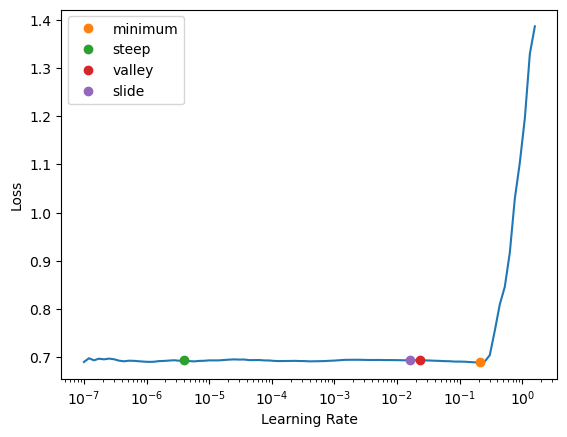

In [67]:
rates = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr = (rates.slide+rates.valley)/2

In [71]:

# Train the model
# learn.fit(100, lr, cbs=EarlyStoppingCallback(monitor='binary_acc', min_delta=0.0001, patience=10))
learn.fit_one_cycle(100, cbs=EarlyStoppingCallback(monitor='binary_acc', min_delta=0.0001, patience=10))

epoch,train_loss,valid_loss,binary_acc,time
0,0.724089,0.715266,49.892704,00:00
1,0.717441,0.713931,49.892704,00:00
2,0.720417,0.711985,49.892704,00:00
3,0.717115,0.709752,50.030045,00:00
4,0.716298,0.706886,49.892704,00:00
5,0.715546,0.703437,50.579399,00:00
6,0.712435,0.699830,50.716740,00:00
7,0.706940,0.696369,51.403435,00:00
8,0.704300,0.692898,53.145924,00:00
9,0.700988,0.690075,53.339054,00:00


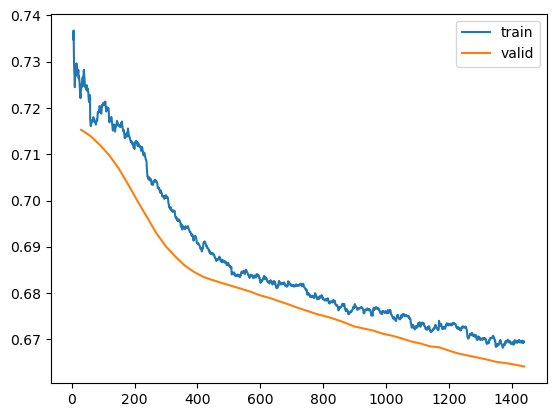

In [72]:
learn.recorder.plot_loss()

In [73]:
learn.summary()

Net (Input shape: 128 x 92)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 1             
Linear                                    93         True      
____________________________________________________________________________

Total params: 93
Total trainable params: 93
Total non-trainable params: 0

Optimizer used: <function SGD at 0x17f58f820>
Loss function: BCEWithLogitsLoss()

Model unfrozen

Callbacks:
  - TrainEvalCallback
  - CastToTensor
  - Recorder
  - ProgressCallback

In [79]:
# evaluate the model on the test set
model = nn.Sequential(learn.model, nn.Sigmoid())
y_pred = model(torch.from_numpy(X_test).float())
# y_pred, _ = learn.get_preds(dl=dls.test_dl(test_ds))
# y_pred = nn.Sigmoid()(y_pred)
# print(y_pred)
y_pred = (y_pred>0.5).int()
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.64      0.65      0.65       233
           1       0.65      0.64      0.64       233

    accuracy                           0.64       466
   macro avg       0.64      0.64      0.64       466
weighted avg       0.64      0.64      0.64       466



## FastAI Approach 2 (tabular net)

In [531]:
# create a pandas dataframe from the numpy arrays
train_df = pd.DataFrame(data=np.c_[X_train, y_train], columns=[f'feat_{i}' for i in range(X_train.shape[1])] + ['label'])
valid_df = pd.DataFrame(data=np.c_[X_val, y_val], columns=[f'feat_{i}' for i in range(X_val.shape[1])] + ['label'])

# merge the train and validation set
combined_df = pd.concat([train_df, valid_df], axis=0)
val_df_idx = np.arange(len(train_df), len(combined_df))
print(len(train_df), len(val_df_idx), len(combined_df))

# define your dependent and independent variables
dep_var = 'label'
cat_names = []
cont_names = [f'feat_{i}' for i in range(X_train.shape[1])]

# define your processors, which can be used to normalize your data
procs = [Normalize]

dls = TabularDataLoaders.from_df(
    combined_df, 
    procs=procs, 
    cat_names=cat_names, 
    cont_names=cont_names, 
    y_names=dep_var, 
    valid_idx=val_df_idx, 
    bs=64, 
    y_block=CategoryBlock
    )

3725 466 4191


In [506]:
batch = dls.one_batch()
print(batch[1].dtype, batch[2].dtype)
print(batch[1].shape, batch[2].shape)

torch.float32 torch.int8
torch.Size([64, 92]) torch.Size([64, 1])


In [507]:
# learn = tabular_learner(dls, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learn = tabular_learner(dls, metrics=accuracy)
# learn = Learner(dls, nn.Linear(92, 1), opt_func=SGD, loss_func=nn.BCEWithLogitsLoss())
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=92, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [508]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

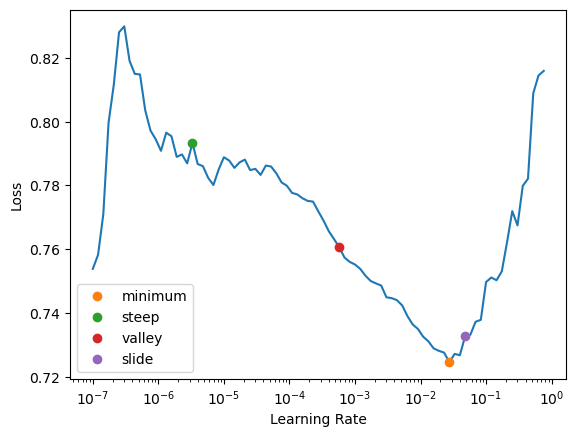

In [510]:
rates = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [511]:
lr = (rates.slide+rates.valley)/2
lr

0.02421922513167374

In [557]:
# learn.fit_one_cycle(10, lr, cbs=[ShowGraphCallback()])
learn.fit(10, lr, cbs=[ShowGraphCallback()]) 

epoch,train_loss,valid_loss,binary_acc,time
0,0.628188,0.606281,64.433479,00:00
1,0.626689,0.605925,64.845497,00:00
2,0.631268,0.605577,64.845497,00:00
3,0.631736,0.621500,64.145920,00:00
4,0.625672,0.610874,64.982834,00:00
5,0.631193,0.617250,61.824036,00:00
6,0.629788,0.614725,62.236050,00:00
7,0.629657,0.622222,61.000000,00:00
8,0.628123,0.605743,66.356224,00:00
9,0.623717,0.607265,64.927040,00:00


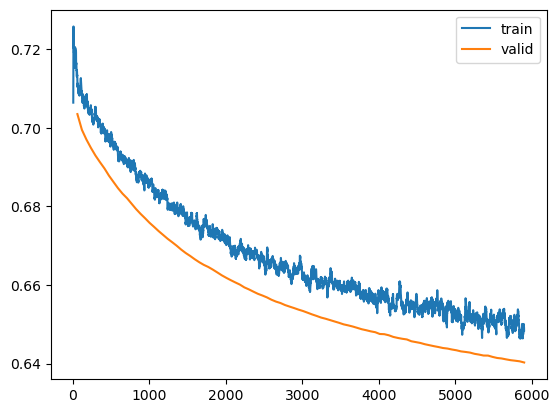

In [560]:
learn.recorder.plot_loss()

In [561]:
learn.summary()

Net (Input shape: 64 x 92)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 1              
Linear                                    93         True      
____________________________________________________________________________

Total params: 93
Total trainable params: 93
Total non-trainable params: 0

Optimizer used: <function SGD at 0x16524d820>
Loss function: BCEWithLogitsLoss()

Model unfrozen

Callbacks:
  - TrainEvalCallback
  - CastToTensor
  - Recorder
  - ProgressCallback

In [567]:
# evaluate the model on the test set
y_pred, _ = learn.get_preds(dl=dls.valid)
y_pred = (y_pred[:,1]>0.5).int()
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.63      0.65       237
           1       0.64      0.67      0.65       229

    accuracy                           0.65       466
   macro avg       0.65      0.65      0.65       466
weighted avg       0.65      0.65      0.65       466



In [532]:
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(92, 1)
        
    def forward(self, x):
        x = self.fc(x)
        x = nn.Sigmoid()(x)
        return x

# Initialize the model and optimizer
model = Net()

# define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# train model
for epoch in range(100):
    for _, xb, yb in dls.train:
        # forward pass
        pred = model(xb)
        loss = criterion(pred.squeeze(), yb.squeeze())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # evaluate on validation set
    with torch.no_grad():
        val_loss = sum(criterion(model(xb).squeeze(), yb.squeeze()) for _, xb, yb in dls.valid) / len(dls.valid)
        print(f"Epoch {epoch+1}, training loss: {loss}, validation loss: {val_loss}, accuracy: {accuracy(pred, yb)}")


Epoch 1, training loss: 0.6964849829673767, validation loss: 0.6806973814964294, accuracy: TensorBase(0.4375)
Epoch 2, training loss: 0.6605525612831116, validation loss: 0.6693177223205566, accuracy: TensorBase(0.4531)
Epoch 3, training loss: 0.6668044328689575, validation loss: 0.6611661911010742, accuracy: TensorBase(0.4531)
Epoch 4, training loss: 0.6786819696426392, validation loss: 0.6551483869552612, accuracy: TensorBase(0.4062)
Epoch 5, training loss: 0.6397011876106262, validation loss: 0.6509966850280762, accuracy: TensorBase(0.4062)
Epoch 6, training loss: 0.647949755191803, validation loss: 0.6470600366592407, accuracy: TensorBase(0.3750)
Epoch 7, training loss: 0.6969434022903442, validation loss: 0.647231936454773, accuracy: TensorBase(0.4844)
Epoch 8, training loss: 0.6390050053596497, validation loss: 0.641717255115509, accuracy: TensorBase(0.5469)
Epoch 9, training loss: 0.6474009156227112, validation loss: 0.6398457288742065, accuracy: TensorBase(0.5312)
Epoch 10, tra

## Keras/Tensorflow Approach

In [31]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# Define the model architecture
model = keras.models.Sequential([
    keras.layers.Dense(units=1, input_shape=(92,), activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [32]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/100
 5/59 [=>............................] - ETA: 0s - loss: 0.9105 - accuracy: 0.5500 

2023-04-09 21:49:54.874618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 1s 11ms/step - loss: 0.7717 - accuracy: 0.5047 - val_loss: 0.7259 - val_accuracy: 0.5064
Epoch 2/100
 8/59 [===>..........................] - ETA: 0s - loss: 0.7211 - accuracy: 0.5137

2023-04-09 21:49:55.525936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 0s 8ms/step - loss: 0.7223 - accuracy: 0.5138 - val_loss: 0.7112 - val_accuracy: 0.5150
Epoch 3/100
59/59 [==============================] - 0s 7ms/step - loss: 0.7075 - accuracy: 0.5361 - val_loss: 0.6978 - val_accuracy: 0.5365
Epoch 4/100
59/59 [==============================] - 0s 7ms/step - loss: 0.6964 - accuracy: 0.5409 - val_loss: 0.6887 - val_accuracy: 0.5451
Epoch 5/100
59/59 [==============================] - 0s 6ms/step - loss: 0.6878 - accuracy: 0.5581 - val_loss: 0.6815 - val_accuracy: 0.5858
Epoch 6/100
59/59 [==============================] - 1s 9ms/step - loss: 0.6807 - accuracy: 0.5694 - val_loss: 0.6756 - val_accuracy: 0.5794
Epoch 7/100
59/59 [==============================] - 0s 7ms/step - loss: 0.6767 - accuracy: 0.5672 - val_loss: 0.6704 - val_accuracy: 0.5944
Epoch 8/100
59/59 [==============================] - 0s 7ms/step - loss: 0.6722 - accuracy: 0.5807 - val_loss: 0.6677 - val_accuracy: 0.6030
Epoch 9/100
59/59 [======

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


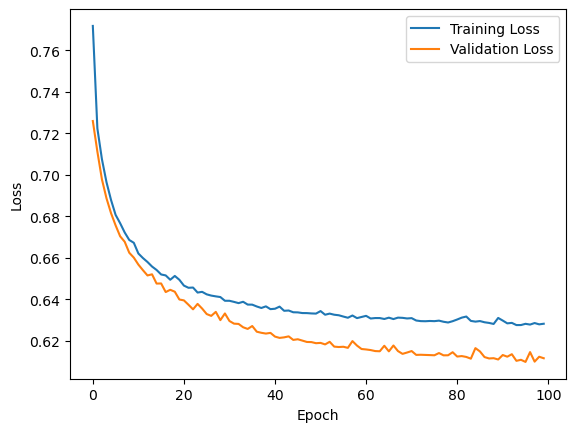

In [34]:
# plot the training and validation loss
# Get the training and validation loss history
print(history.history.keys())

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5).astype(int)
print(classification_report(y_test, y_pred))

15/15 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       233
           1       0.67      0.67      0.67       233

    accuracy                           0.67       466
   macro avg       0.67      0.67      0.67       466
weighted avg       0.67      0.67      0.67       466



2023-04-09 21:51:26.283021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Single LSTM Layer Test
Instead of using welch, pass in individual STFT time frames to a single recurrent layer.

Try out bayesian hyperparameter search for regularization and dropout params.

In [8]:
# initialize sequential data
scaler = StandardScaler()

# log psd features in sensorimotor range
X_train = train_stft[:, :, np.logical_and(freqs >= 8, freqs <= 30), :]
print(X_train.shape)

# merge channel and fft axis (1, 2)
# move time axis to position 1 from 2 (keras format)
X_train = np.moveaxis(X_train.reshape(X_train.shape[0], -1, X_train.shape[-1]), 2, 1)
X_train = scaler.fit_transform(X_train.reshape((X_train.shape[0]*X_train.shape[1],X_train.shape[2]))).reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2]))
print(X_train.shape)

X_val = val_stft[:, :, np.logical_and(freqs >= 8, freqs <= 30), :]
print(X_val.shape)
X_val = np.moveaxis(X_val.reshape(X_val.shape[0], -1, X_val.shape[-1]), 2, 1)
X_val = scaler.transform(X_val.reshape((X_val.shape[0]*X_val.shape[1],X_val.shape[2]))).reshape((X_val.shape[0],X_val.shape[1],X_val.shape[2]))
print(X_val.shape)

X_test = test_stft[:, :, np.logical_and(freqs >= 8, freqs <= 30), :]
print(X_test.shape)
X_test = np.moveaxis(X_test.reshape(X_test.shape[0], -1, X_test.shape[-1]), 2, 1)
X_test = scaler.transform(X_test.reshape((X_test.shape[0]*X_test.shape[1],X_test.shape[2]))).reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2]))
print(X_test.shape)

(3725, 4, 23, 9)
(3725, 9, 92)
(466, 4, 23, 9)
(466, 9, 92)
(466, 4, 23, 9)
(466, 9, 92)


## Keras/Tensorflow Approach

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout
from keras.regularizers import l2
import keras_tuner as kt
from keras.optimizers import Adam


In [12]:
def build_model(hp):
    model = Sequential()
    model.add(Dropout(hp.Float("input_dropout_rate", min_value=0.0, max_value=0.2, step=0.1)))
    if hp.Choice("batch_norm1", values=[True, False]):
        model.add(BatchNormalization())
    model.add(LSTM(
    hp.Int("dense_units", min_value=16,
		max_value=128, step=16), 
    input_shape=(9, 92), 
    dropout=hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.1),
    kernel_regularizer=l2(hp.Float("kl2_lstm", min_value=0.0, max_value=0.1, step=0.01)),
    recurrent_regularizer=l2(hp.Float("rl2_lstm", min_value=0.0, max_value=0.1, step=0.01)),
    bias_regularizer=l2(hp.Float("bl2_lstm", min_value=0.0, max_value=0.1, step=0.01)),
    recurrent_dropout=hp.Float("rdropout", min_value=0.0, max_value=0.5, step=0.1)
    ))
    if hp.Choice('batch_norm2', values=[True, False]):
        model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid', 
    kernel_regularizer=l2(hp.Float("kl2_dense", min_value=0.0, max_value=0.1, step=0.01)),
    bias_regularizer=l2(hp.Float("bl2_dense", min_value=0.0, max_value=0.1, step=0.01)),
    # dropout=hp.Float("dropout_dense", min_value=0.0, max_value=0.5, step=0.1)
    ))

    lr = hp.Choice("learning_rate",
      values=[1e-1, 1e-2, 1e-3])
    opt = Adam(learning_rate=lr)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    project_name='lstm_tuner',
)

tuner.search(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))

Trial 10 Complete [00h 01m 27s]
val_accuracy: 0.6502146124839783

Best val_accuracy So Far: 0.6695278882980347
Total elapsed time: 00h 02m 54s
INFO:tensorflow:Oracle triggered exit


In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'input_dropout': 0, 'input_dropout_rate': 0.1, 'batch_norm1': 1, 'dense_units': 128, 'dropout': 0.0, 'kl2_lstm': 0.1, 'rl2_lstm': 0.1, 'bl2_lstm': 0.06, 'rdropout': 0.5, 'batch_norm2': 0, 'kl2_dense': 0.0, 'bl2_dense': 0.1, 'learning_rate': 0.001}


In [16]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/100


2023-04-10 15:27:55.618210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 26.3299 - accuracy: 0.5093

2023-04-10 15:28:03.632821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 9s 260ms/step - loss: 26.3299 - accuracy: 0.5093 - val_loss: 17.6371 - val_accuracy: 0.5386
Epoch 2/100
30/30 [==============================] - 7s 224ms/step - loss: 13.6688 - accuracy: 0.5689 - val_loss: 10.4854 - val_accuracy: 0.5987
Epoch 3/100
30/30 [==============================] - 7s 227ms/step - loss: 9.0823 - accuracy: 0.5922 - val_loss: 7.9218 - val_accuracy: 0.6288
Epoch 4/100
30/30 [==============================] - 7s 236ms/step - loss: 7.3854 - accuracy: 0.6089 - val_loss: 6.8907 - val_accuracy: 0.6567
Epoch 5/100
30/30 [==============================] - 7s 221ms/step - loss: 6.6227 - accuracy: 0.6156 - val_loss: 6.3381 - val_accuracy: 0.6459
Epoch 6/100
30/30 [==============================] - 7s 221ms/step - loss: 6.1512 - accuracy: 0.6030 - val_loss: 5.9339 - val_accuracy: 0.6223
Epoch 7/100
30/30 [==============================] - 7s 229ms/step - loss: 5.7733 - accuracy: 0.6113 - val_loss: 5.5696 - val_accuracy: 0.6695
Epoch 8

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 9, 92)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 9, 92)            368       
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 128)               113152    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 113,649
Trainable params: 113,465
Non-trainable params: 184
_________________________________________________________________


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


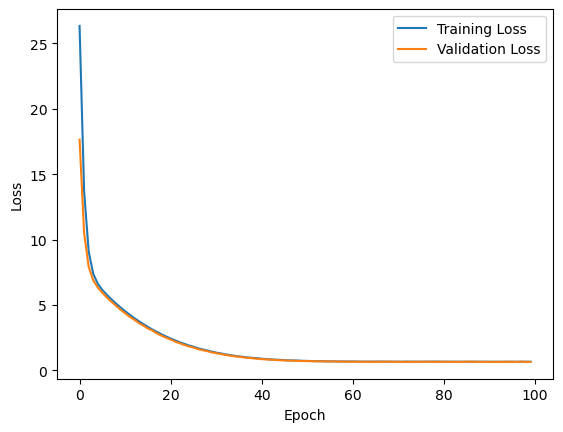

In [18]:
# plot the training and validation loss
# Get the training and validation loss history
print(history.history.keys())

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 39ms/step - loss: 0.6520 - accuracy: 0.6202


[0.6519922018051147, 0.6201716661453247]

In [20]:
# evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5).astype(int)
print(classification_report(y_test, y_pred))

 1/15 [=>............................] - ETA: 4s

2023-04-10 15:41:47.509533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

           0       0.61      0.64      0.63       233
           1       0.63      0.60      0.61       233

    accuracy                           0.62       466
   macro avg       0.62      0.62      0.62       466
weighted avg       0.62      0.62      0.62       466



Manual parameter tuning after search

In [10]:
hps_dict = {
    'input_dropout': 0, 
    'input_dropout_rate': 0.1, 
    'batch_norm1': 1, 
    'dense_units': 128, 
    'dropout': 0.0, 
    'kl2_lstm': 0.1, 
    'rl2_lstm': 0.1, 
    'bl2_lstm': 0.06, 
    'rdropout': 0.5, 
    'batch_norm2': 0, 
    'kl2_dense': 0.0, 
    'bl2_dense': 0.1, 
    'learning_rate': 0.001
}

model = Sequential()
# non reg
# model.add(LSTM(32, input_shape=(9, 92)))
# model.add(Dense(1, activation='sigmoid'))

# L2 reg
# model.add(LSTM(64, input_shape=(9, 92), kernel_regularizer=l2(0.01)))
# model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Dropout
model.add(LSTM(64, input_shape=(9, 92), dropout=0.1))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


2023-04-13 05:35:17.728483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-13 05:35:17.729076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                40192     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 40,513
Trainable params: 40,385
Non-trainable params: 128
_________________________________________________________________


In [11]:
# callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, mode='min', restore_best_weights=True)

# history = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_val, y_val), callbacks=[callback])
history_lstm = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100


2023-04-13 05:35:32.887086: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-13 05:35:33.448431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-13 05:35:33.716499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/30 [>.............................] - ETA: 38s - loss: 0.8615 - accuracy: 0.5156

2023-04-13 05:35:34.072087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.7366 - accuracy: 0.5589

2023-04-13 05:35:34.995814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-13 05:35:35.071119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 36ms/step - loss: 0.7366 - accuracy: 0.5589 - val_loss: 0.6822 - val_accuracy: 0.6009
Epoch 2/100
30/30 [==============================] - 1s 17ms/step - loss: 0.6605 - accuracy: 0.6301 - val_loss: 0.6649 - val_accuracy: 0.6137
Epoch 3/100
30/30 [==============================] - 1s 18ms/step - loss: 0.6351 - accuracy: 0.6459 - val_loss: 0.6496 - val_accuracy: 0.6631
Epoch 4/100
30/30 [==============================] - 1s 17ms/step - loss: 0.6169 - accuracy: 0.6685 - val_loss: 0.6300 - val_accuracy: 0.6845
Epoch 5/100
30/30 [==============================] - 1s 17ms/step - loss: 0.5997 - accuracy: 0.6821 - val_loss: 0.6181 - val_accuracy: 0.6953
Epoch 6/100
30/30 [==============================] - 1s 19ms/step - loss: 0.5856 - accuracy: 0.6969 - val_loss: 0.5891 - val_accuracy: 0.7210
Epoch 7/100
30/30 [==============================] - 1s 19ms/step - loss: 0.5640 - accuracy: 0.7170 - val_loss: 0.5826 - val_accuracy: 0.7210
Epoch 8/100
30/30 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


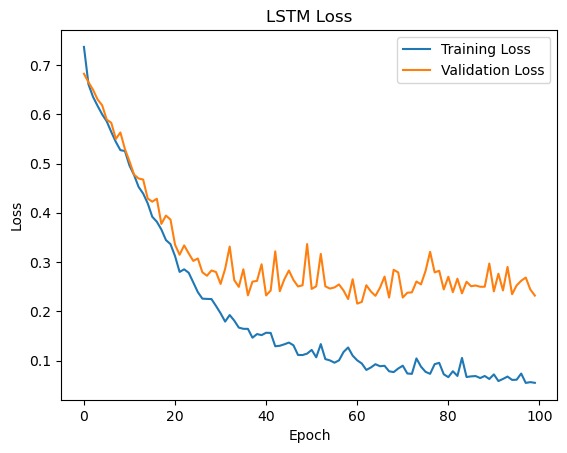

In [14]:
# plot the training and validation loss
# Get the training and validation loss history
print(history_lstm.history.keys())

# Plot the training and validation loss
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

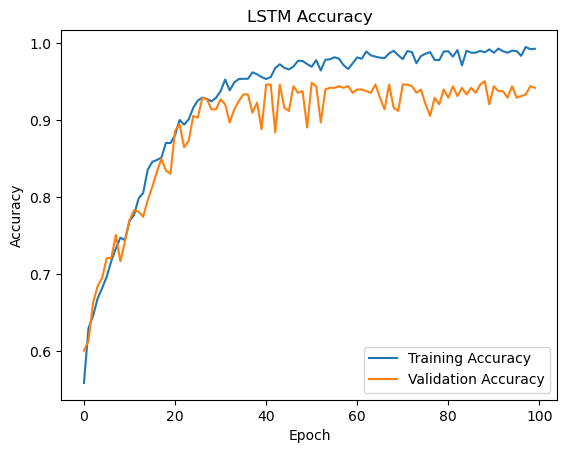

In [15]:
# plot accuracy
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
model.evaluate(X_test, y_test) # (loss, accuracy)

15/15 [==============================] - 0s 14ms/step - loss: 0.2734 - accuracy: 0.9399


[0.2733709216117859, 0.9399141669273376]

In [16]:
# evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5).astype(int)
print(classification_report(y_test, y_pred))

10/15 [===================>..........] - ETA: 0s

2023-04-13 05:39:05.951206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-13 05:39:06.017537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       233
           1       0.94      0.94      0.94       233

    accuracy                           0.94       466
   macro avg       0.94      0.94      0.94       466
weighted avg       0.94      0.94      0.94       466



In [17]:
model.save('lstm_model')

INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


# Legendre Memory Unit

In [18]:
import nengo
from nengo.utils.filter_design import cont2discrete
import nengo_dl

# reshape labels to rank 3 as expected in Nengo)
y_train_3 = y_train.reshape((y_train.shape[0], 1, 1))
y_val_3 = y_val.reshape((y_val.shape[0], 1, 1))
y_test_3 = y_test.reshape((y_test.shape[0], 1, 1))

print(X_test.shape, y_test_3.shape)

(466, 9, 92) (466, 1, 1)


## In Nengo-DL

In [50]:
class LMUCell(nengo.Network):
    def __init__(self, units, order, theta, input_d, **kwargs):
        super().__init__(**kwargs)

        # compute the A and B matrices according to the LMU's mathematical derivation
        # (see the paper for details)
        Q = np.arange(order, dtype=np.float64)
        R = (2 * Q + 1)[:, None] / theta
        j, i = np.meshgrid(Q, Q)

        A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
        B = (-1.0) ** Q[:, None] * R
        C = np.ones((1, order))
        D = np.zeros((1,))

        A, B, _, _, _ = cont2discrete((A, B, C, D), dt=1.0, method="zoh")

        with self:
            nengo_dl.configure_settings(trainable=None)

            # create objects corresponding to the x/u/m/h variables in the above diagram
            self.x = nengo.Node(size_in=input_d)
            self.u = nengo.Node(size_in=1)
            self.m = nengo.Node(size_in=order)
            self.h = nengo_dl.TensorNode(tf.nn.tanh, shape_in=(units,), pass_time=False)

            # compute u_t from the above diagram. we have removed e_h and e_m as they
            # are not needed in this task.
            nengo.Connection(
                self.x, self.u, transform=np.ones((1, input_d)), synapse=None
            )

            # compute m_t
            # in this implementation we'll make A and B non-trainable, but they
            # could also be optimized in the same way as the other parameters.
            # note that setting synapse=0 (versus synapse=None) adds a one-timestep
            # delay, so we can think of any connections with synapse=0 as representing
            # value_{t-1}.
            conn_A = nengo.Connection(self.m, self.m, transform=A, synapse=0)
            self.config[conn_A].trainable = False
            conn_B = nengo.Connection(self.u, self.m, transform=B, synapse=None)
            self.config[conn_B].trainable = False

            # compute h_t
            nengo.Connection(
                self.x, self.h, transform=nengo_dl.dists.Glorot(), synapse=None
            )
            nengo.Connection(
                self.h, self.h, transform=nengo_dl.dists.Glorot(), synapse=0
            )
            nengo.Connection(
                self.m,
                self.h,
                transform=nengo_dl.dists.Glorot(),
                synapse=None,
            )


In [51]:
with nengo.Network(seed=0) as net:
    # remove some unnecessary features to speed up the training
    nengo_dl.configure_settings(
        trainable=None,
        stateful=False,
        keep_history=False,
    )

    # input node
    inp = nengo.Node(np.zeros(X_train.shape[-1]))

    # lmu cell
    lmu = LMUCell(
        units=128,
        order=64,
        theta=X_train.shape[1], # time segments
        input_d=X_train.shape[-1], # input dimension
    )
    conn = nengo.Connection(inp, lmu.x, synapse=None)
    net.config[conn].trainable = False

    # dense linear readout
    out = nengo.Node(size_in=1)
    nengo.Connection(lmu.h, out, transform=nengo_dl.dists.Glorot(), synapse=None)

    # record output. note that we set keep_history=False above, so this will
    # only record the output on the last timestep (which is all we need
    # on this task)
    p = nengo.Probe(out)

In [52]:
do_training = True

with nengo_dl.Simulator(net, minibatch_size=128, unroll_simulation=3) as sim:
    sim.compile(
        loss=tf.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.optimizers.Adam(),
        metrics=["accuracy"],
    )

    test_acc = sim.evaluate(X_test, y_test_3, verbose=0)["probe_accuracy"]
    print(f"Initial test accuracy: {test_acc * 100:.2f}%")

    if do_training:
        sim.fit(X_train, y_train_3, batch_size=128, epochs=100, validation_data=(X_val, y_val_3))
        sim.save_params("./lmu_params")
    else:
        urlretrieve(
            "https://drive.google.com/uc?export=download&"
            "id=1UbVJ4u6eQkyxIU9F7yScElAz2p2Ah2sP",
            "lmu_params.npz",
        )
        sim.load_params("./lmu_params")

    test_acc = sim.evaluate(X_test, y_test_3, verbose=0)["probe_accuracy"]
    print(f"Final test accuracy: {test_acc * 100:.2f}")

|                     Building network (0%)                    | ETA:  --:--:--
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Cons

/Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/nengo-dl/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (466) is not evenly divisible by Simulator.minibatch_size (128); input data will be truncated.
  warnings.warn(
2023-04-11 02:11:01.049464: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


|##########    Constructing graph: build stage (15%)             | ETA: 0:00:00
|##############Constructing graph: build stage (66%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|###########   Constructing graph: build stage (17%)             | ETA: 0:00:00
|##############Constructing graph: build stage (70%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
Initial test accuracy: 48.96%
Epoch 1/100
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Construc

/Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/nengo-dl/nengo_dl/simulator.py:942: UserWarning: Batch size is determined statically via Simulator.minibatch_size; ignoring value passed to `fit`
  warnings.warn(
/Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/nengo-dl/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (3725) is not evenly divisible by Simulator.minibatch_size (128); input data will be truncated.
  warnings.warn(


|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##########    Constructing graph: build stage (15%)             | ETA: 0:00:00
|##########    Constructing graph: build stage (15%)             | ETA: 0:00:01
|##############Constructing graph: build stage (66%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
29/29 [==============================] - 7s 123ms/step - loss: 0.7286 - probe_loss: 0.7286 - probe_accuracy: 0.5073 - val_loss: 0.6574 - val_probe_loss: 0.6574 - val_probe_accuracy: 0.5547
Epoch 2/100
29/29 [==============================] - 3s 120ms/step - loss: 0.6641 - probe_l

## Using KerasLMU

In [19]:
from keras_lmu import LMU

model = Sequential()
model.add(LMU(
    hidden_cell=tf.keras.layers.SimpleRNNCell(units=64),
    memory_d=4, 
    order=32, 
    theta=X_train.shape[1], 
    input_shape=(X_train.shape[1], X_train.shape[2])
    ))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lmu (LMU)                   (None, 64)                12720     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,785
Trainable params: 12,785
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_lmu = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/100


2023-04-13 05:40:36.789266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.7296 - accuracy: 0.4999

2023-04-13 05:40:41.548713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 6s 158ms/step - loss: 0.7296 - accuracy: 0.4999 - val_loss: 0.6889 - val_accuracy: 0.5536
Epoch 2/100
30/30 [==============================] - 4s 149ms/step - loss: 0.6745 - accuracy: 0.5823 - val_loss: 0.6521 - val_accuracy: 0.6094
Epoch 3/100
30/30 [==============================] - 9s 309ms/step - loss: 0.6465 - accuracy: 0.6236 - val_loss: 0.6226 - val_accuracy: 0.6524
Epoch 4/100
30/30 [==============================] - 5s 176ms/step - loss: 0.6256 - accuracy: 0.6510 - val_loss: 0.6021 - val_accuracy: 0.6674
Epoch 5/100
30/30 [==============================] - 5s 163ms/step - loss: 0.6077 - accuracy: 0.6652 - val_loss: 0.5849 - val_accuracy: 0.6781
Epoch 6/100
30/30 [==============================] - 5s 164ms/step - loss: 0.5902 - accuracy: 0.6881 - val_loss: 0.5766 - val_accuracy: 0.6910
Epoch 7/100
30/30 [==============================] - 5s 171ms/step - loss: 0.5793 - accuracy: 0.6953 - val_loss: 0.5615 - val_accuracy: 0.6953
Epoch 8/100

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


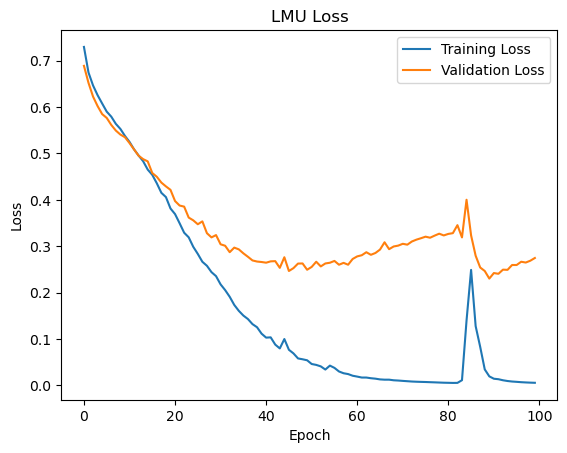

In [21]:
# plot the training and validation loss
# Get the training and validation loss history
print(history_lmu.history.keys())

# Plot the training and validation loss
plt.plot(history_lmu.history['loss'], label='Training Loss')
plt.plot(history_lmu.history['val_loss'], label='Validation Loss')
plt.title('LMU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

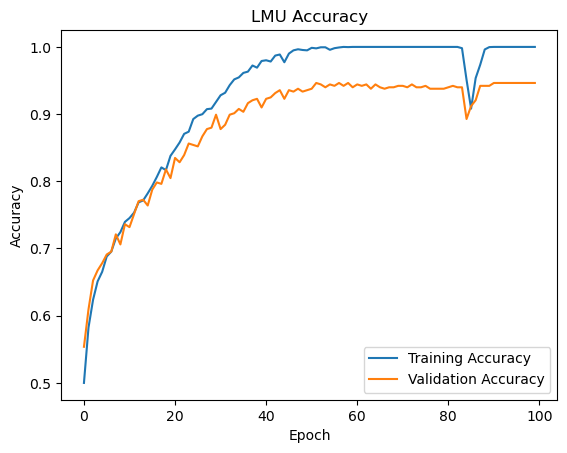

In [24]:
# Plot the training and validation accuracy
plt.plot(history_lmu.history['accuracy'], label='Training Accuracy')
plt.plot(history_lmu.history['val_accuracy'], label='Validation Accuracy')
plt.title('LMU Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
model.evaluate(X_test, y_test) # (val_loss, val_acc)

15/15 [==============================] - 1s 37ms/step - loss: 0.3607 - accuracy: 0.9313


[0.3607419431209564, 0.9313304424285889]

In [23]:
# evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5).astype(int)
print(classification_report(y_test, y_pred))

 3/15 [=====>........................] - ETA: 0s

2023-04-13 05:49:26.631368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       233
           1       0.92      0.94      0.93       233

    accuracy                           0.93       466
   macro avg       0.93      0.93      0.93       466
weighted avg       0.93      0.93      0.93       466



In [87]:
import keras_spiking

@keras_spiking.ModelEnergy.register_layer(LMU)
def LMU_stats(node):
    input_d = 92
    units = 64
    order = 32

    # Connections: three sets of connections (x->h, m->h, h->h)
    connections_x_to_h = input_d * units
    connections_m_to_h = order * units
    connections_h_to_h = units * units
    connections = connections_x_to_h + connections_m_to_h + connections_h_to_h

    # Neurons: number of neurons in the LMU is equal to the number of units
    neurons = units

    return {"connections": connections, "neurons": neurons, "spiking": True}

energy = keras_spiking.ModelEnergy(model, example_data=X_test)
energy.summary(
     columns=(
        "name",
        "energy cpu",
        "energy loihi",
        "energy gpu",
        "synop_energy cpu",
        "synop_energy gpu",
        "neuron_energy cpu",
        "neuron_energy gpu",
    ),
    timesteps_per_inference=9,
    dt=0.001,
    print_warnings=False)


 1/15 [=>............................] - ETA: 2s

/Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/keras-spiking/keras_spiking/model_energy.py:318: UserWarning: Layer 'LMU' already registered. Overwriting.
  warnings.warn(
2023-04-11 22:24:40.038614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 23ms/step
Layer (type|J/inf (cpu)|J/inf (loih|J/inf (gpu)|Synop J/inf |Synop J/inf|Neuron J/inf|Neuron J/inf
-----------|-----------|-----------|-----------|------------|-----------|------------|------------
lmu_14 (LMU|     0.0001|    4.9e-08|    3.6e-06|      0.0001|    3.6e-06|     5.5e-07|     1.9e-08
dense_14 (D|    5.6e-07|    7.4e-10|    1.9e-08|     5.5e-07|    1.9e-08|     8.6e-09|       3e-10
Total energy per inference [Joules/inf] (cpu): 1.05e-04
Total energy per inference [Joules/inf] (loihi): 4.98e-08
Total energy per inference [Joules/inf] (gpu): 3.65e-06


In [25]:
# save the model

model.save('keras-lmu')

INFO:tensorflow:Assets written to: keras-lmu/assets


INFO:tensorflow:Assets written to: keras-lmu/assets


# Spiking LMU

In [26]:
class SpikingLMUCell(nengo.Network):
    def __init__(self, units, order, theta, input_d, **kwargs):
        super().__init__(**kwargs)

        # compute the A and B matrices according to the LMU's mathematical derivation
        # (see the paper for details)
        Q = np.arange(order, dtype=np.float64)
        R = (2 * Q + 1)[:, None] / theta
        j, i = np.meshgrid(Q, Q)

        A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
        B = (-1.0) ** Q[:, None] * R
        C = np.ones((1, order))
        D = np.zeros((1,))
        
#          here we are using zero-order hold(zoh) method to 
#        discretize the value of A and B 
        A, B, _, _, _ = cont2discrete((A, B, C, D), dt=1.0, method="zoh")

        with self:
            nengo_dl.configure_settings(trainable=None)

            # create objects corresponding to the x/u/m/h variables in the above diagram
            self.x = nengo.Node(size_in=input_d)
            self.u = nengo.Node(size_in=1)
            self.m = nengo.Node(size_in=order)
#             self.h = nengo_dl.TensorNode(tf.nn.relu, shape_in=(units,), pass_time=False)
            self.h = nengo.Ensemble(units, 1, 
                                    #neuron_type=nengo.RegularSpiking(nengo.Tanh(tau_ref=0.001)), 
                                    neuron_type=nengo.Tanh(tau_ref=1), 
                                    gain=np.ones(units), bias=np.zeros(units)).neurons  

#             compute u_t from the above diagram. we have removed e_h and e_m as they
#             are not needed in this task.
            nengo.Connection(
                self.x,
                self.u,
                transform=np.ones((1, input_d)),
                synapse=None,
            )

            # compute m_t
            # in this implementation we'll make A and B non-trainable, but they
            # could also be optimized in the same way as the other parameters.
            # note that setting synapse=0 (versus synapse=None) adds a one-timestep
            # delay, so we can think of any connections with synapse=0 as representing
            # value_{t-1}.
            conn_A = nengo.Connection(
                self.m,
                self.m,
                transform=A,
                synapse=0,
            )
            self.config[conn_A].trainable = False
            
            conn_B = nengo.Connection(
                self.u,
                self.m,
                transform=B,
                synapse=None,
            )
            self.config[conn_B].trainable = False

            # compute h_t
            nengo.Connection(
                self.x,
                self.h,
                transform=nengo_dl.dists.Glorot(),
                synapse=None,
            )
            nengo.Connection(
                self.h,
                self.h,
                transform=nengo_dl.dists.Glorot(),
                synapse=0,
            )
            nengo.Connection(
                self.m,
                self.h,
                transform=nengo_dl.dists.Glorot(),
                synapse=None,
            )
            
            

In [29]:
with nengo.Network(seed=0) as net:
    nengo_dl.configure_settings(
        trainable=None,
        stateful=None,
        keep_history=False,
    )

    inp = nengo.Node((np.zeros(X_train.shape[-1])))

    lmu = SpikingLMUCell(
        units=64,
        order=32,
        theta=X_train.shape[1],
        input_d=X_train.shape[-1],
    )
    net.config[lmu.h.ensemble].trainable = False
    
    conn = nengo.Connection(inp, lmu.x, synapse=None)
    net.config[conn].trainable = False 

    out = nengo.Node(size_in=1) #changed to 1
    nengo.Connection(lmu.h, out, transform=nengo_dl.dists.Glorot(), synapse=None)
   
    # p_inp = nengo.Probe(inp, label = "input")
    # p_lmu = nengo.Probe(lmu.h, label = "lmu")
    # p = nengo.Probe(out, label = "output") 
    p = nengo.Probe(out)  
    


In [30]:
with nengo_dl.Simulator(net, minibatch_size=128, unroll_simulation=3, progress_bar=False) as sim:
    sim.compile(
        loss=tf.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.optimizers.Adam(),
        metrics=['accuracy']
    )
    sim.keras_model.summary()
    history_lmu_spiking = sim.fit(X_train, y_train_3, batch_size=128, epochs=100, validation_data=(X_val, y_val_3))
    sim.save_params("./spikingLMU_params")
    
    test_acc = sim.evaluate(X_test, y_test_3, verbose=0)["probe_accuracy"]
    print(f"Final test accuracy: {test_acc * 100:.2f}")

Model: "keras_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node (InputLayer)              [(128, None, 92)]    0           []                               
                                                                                                  
 n_steps (InputLayer)           [(128, 1)]           0           []                               
                                                                                                  
 TensorGraph (TensorGraph)      [(128, None, 1),     13244       ['node[0][0]',                   
                                 (128,)]                          'n_steps[0][0]']                
                                                                                                  
Total params: 13,244
Trainable params: 12,188
Non-trainable params: 1,056
______________

/Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/nengo-dl/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (466) is not evenly divisible by Simulator.minibatch_size (128); input data will be truncated.
  warnings.warn(
/Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/nengo-dl/nengo_dl/simulator.py:942: UserWarning: Batch size is determined statically via Simulator.minibatch_size; ignoring value passed to `fit`
  warnings.warn(
/Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/nengo-dl/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (3725) is not evenly divisible by Simulator.minibatch_size (128); input data will be truncated.
  warnings.warn(
2023-04-13 05:52:03.091684: I tensorflow/core/grappler/optimizers/custom_graph_optimiz

29/29 [==============================] - ETA: 0s - loss: 0.7501 - probe_loss: 0.7501 - probe_accuracy: 0.4906

2023-04-13 05:52:08.096333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 7s 148ms/step - loss: 0.7501 - probe_loss: 0.7501 - probe_accuracy: 0.4906 - val_loss: 0.7229 - val_probe_loss: 0.7229 - val_probe_accuracy: 0.4792
Epoch 2/100
29/29 [==============================] - 3s 118ms/step - loss: 0.6961 - probe_loss: 0.6961 - probe_accuracy: 0.5210 - val_loss: 0.6968 - val_probe_loss: 0.6968 - val_probe_accuracy: 0.5286
Epoch 3/100
29/29 [==============================] - 4s 120ms/step - loss: 0.6756 - probe_loss: 0.6756 - probe_accuracy: 0.5480 - val_loss: 0.6829 - val_probe_loss: 0.6829 - val_probe_accuracy: 0.5443
Epoch 4/100
29/29 [==============================] - 4s 136ms/step - loss: 0.6594 - probe_loss: 0.6594 - probe_accuracy: 0.5609 - val_loss: 0.6674 - val_probe_loss: 0.6674 - val_probe_accuracy: 0.5573
Epoch 5/100
29/29 [==============================] - 4s 143ms/step - loss: 0.6458 - probe_loss: 0.6458 - probe_accuracy: 0.5730 - val_loss: 0.6560 - val_probe_loss: 0.6560 - val_probe_accuracy: 0.5625
Epoch 6

dict_keys(['loss', 'probe_loss', 'probe_accuracy', 'val_loss', 'val_probe_loss', 'val_probe_accuracy'])


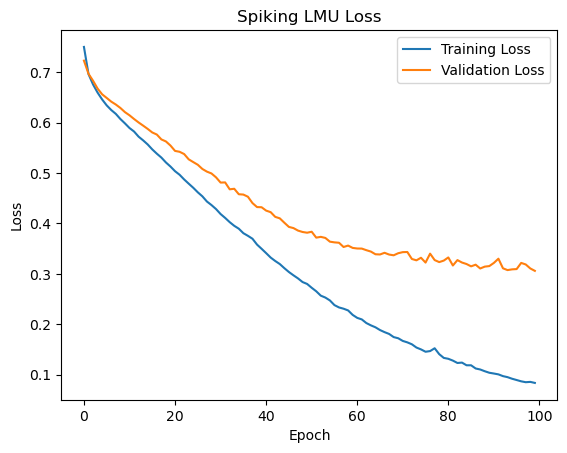

In [31]:
# plot the training and validation loss
# Get the training and validation loss history
print(history_lmu_spiking.history.keys())

# Plot the training and validation loss
plt.plot(history_lmu_spiking.history['loss'], label='Training Loss')
plt.plot(history_lmu_spiking.history['val_loss'], label='Validation Loss')
plt.title("Spiking LMU Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

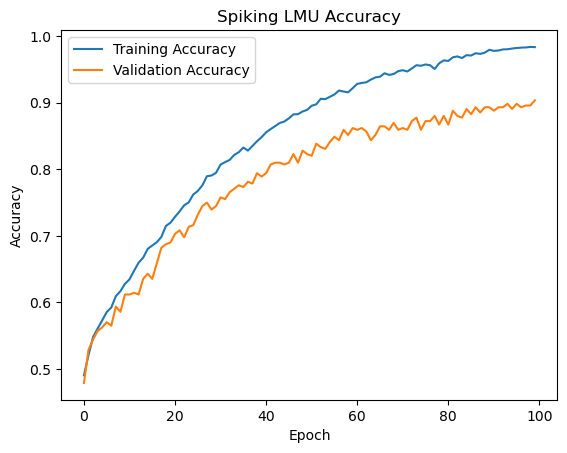

In [32]:
# Plot the training and validation accuracy
plt.plot(history_lmu_spiking.history['probe_accuracy'], label='Training Accuracy')
plt.plot(history_lmu_spiking.history['val_probe_accuracy'], label='Validation Accuracy')
plt.title("Spiking LMU Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Performance Eval

In [63]:
with nengo_dl.Simulator(net, minibatch_size=y_test[0], unroll_simulation=3, progress_bar=False) as sim:
    sim.compile(
        loss=tf.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.optimizers.Adam(),
        metrics=['accuracy']
    )
    sim.keras_model.summary()
    sim.load_params("./spikingLMU_params")

    test_pred = sim.predict(X_test)
    # print(list(test_pred.values())[0].shape)

    y_pred = (list(test_pred.values())[0].flatten()>0.5).astype(int)
    print(classification_report(y_test, y_pred))
    
    # evaluate the model on the test set
    test_acc = sim.evaluate(X_test, y_test_3, verbose=0)["probe_accuracy"]
    print(f"Final test accuracy: {test_acc * 100:.2f}")

Model: "keras_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node (InputLayer)              [(1, None, 92)]      0           []                               
                                                                                                  
 n_steps (InputLayer)           [(1, 1)]             0           []                               
                                                                                                  
 TensorGraph (TensorGraph)      [(1, None, 1),       13244       ['node[0][0]',                   
                                 (1,)]                            'n_steps[0][0]']                
                                                                                                  
Total params: 13,244
Trainable params: 12,188
Non-trainable params: 1,056
______________

2023-04-11 22:06:10.621755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


466/466 [==============================] - 14s 28ms/step
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       233
           1       0.93      0.88      0.91       233

    accuracy                           0.91       466
   macro avg       0.91      0.91      0.91       466
weighted avg       0.91      0.91      0.91       466



2023-04-11 22:06:24.626292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Final test accuracy: 90.99
